In [1]:
import glob
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.applications import vgg16
from keras.models import Model
import keras
import pandas as pd

%matplotlib inline

Using TensorFlow backend.


In [2]:
# we load up the dataset containing 25000 dogs and cats images
files_train = glob.glob('train/*')
files_test = glob.glob('test/*')

In [3]:
missing_train = [fn for fn in files_train if 'WhatsApp' in fn]
Nomissing_train = list(set(files_train) - set(missing_train))
len(missing_train), len(Nomissing_train)

(74, 503)

In [4]:
missing_test = [fn for fn in files_test if 'WhatsApp' in fn]
Nomissing_test = list(set(files_test) - set(missing_test))
len(missing_test), len(Nomissing_test)

(22, 131)

In [5]:
#concztenating files
train_files = np.concatenate([Nomissing_train, missing_train])
test_files =  np.concatenate([Nomissing_test, missing_test])

In [6]:
# set the img dimension size (150,150), transform images into arrays and get the imgs labels. Each image will be at the end
# an array of dimensions(150,150,3) the 3 is for red, green and blue (RGB) channels.
IMG_DIM = (150, 150)

train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM))
              for img in train_files]
train_imgs = np.array(train_imgs)

#train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

test_imgs = [img_to_array(
    load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)

#validation_labels = [fn.split('\\')[1].split('.')[0].strip()
                     #for fn in validate_files]
    

print('Train dataset shape:', train_imgs.shape,
      '\tValidation dataset shape:', test_imgs.shape)

C:\Users\alejandro.ballestero\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\Image.py:2731: DecompressionBombWarning: Image size (99630000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
C:\Users\alejandro.ballestero\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train dataset shape: (577, 150, 150, 3) 	Validation dataset shape: (153, 150, 150, 3)


(150, 150, 3)


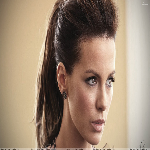

In [7]:
# we now scale each image pixel values from (0,255) to (0,1) range. Deep learning models usually perforn better with small
# input values.

train_imgs = train_imgs.astype('float32')/255
test_imgs = test_imgs.astype('float32')/255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [8]:
train_labels_non= [0 for i in range (len(Nomissing_train))]
train_labels_miss= [1 for i in range (len(missing_train))]
train_labels = train_labels_non + train_labels_miss

print(len(train_labels))

test_labels_non= [0 for i in range (len(Nomissing_test))]
test_labels_miss= [1 for i in range (len(missing_test))]
test_labels = test_labels_non + test_labels_miss

print(len(test_labels))

577
153


# Image augmentation.
## we will add more training data by using a technique called "IMAGE AUGMENTATION".
The idea behind image augmentation is that we follow a set process of taking in existing images from our training dataset
and applying some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, 
to produce new, altered versions of existing images. Due to these random transformations, we don’t get the same images each time.
keras frame work has a excellent tool called "ImagedataGenerator"

In [9]:
# lets initialize two of the data generatos for our trainig and validation sets.

train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

 + Zooming the image randomly by a factor of **0.3** using the **zoom_range** parameter.  
 + Rotating the image randomly by **50** degrees using the **rotation_range** parameter.  
 * Translating the image randomly horizontally or vertically by a **0.2** factor of the image’s width or height using the **width_shift_range** and the **height_shift_range** parameters.  
 * Applying shear-based transformations randomly using the **shear_range** parameter.
 + Randomly flipping half of the images horizontally using the **horizontal_flip** parameter.  
 + Leveraging the **fill_mode** parameter to fill in new pixels for images after we apply any of the preceding operations (especially rotation or translation). In this case, we just fill in the new pixels with their nearest surrounding pixel values.

Labels [0, 0, 0, 0, 0]
Labels [1, 1, 1, 1, 1]


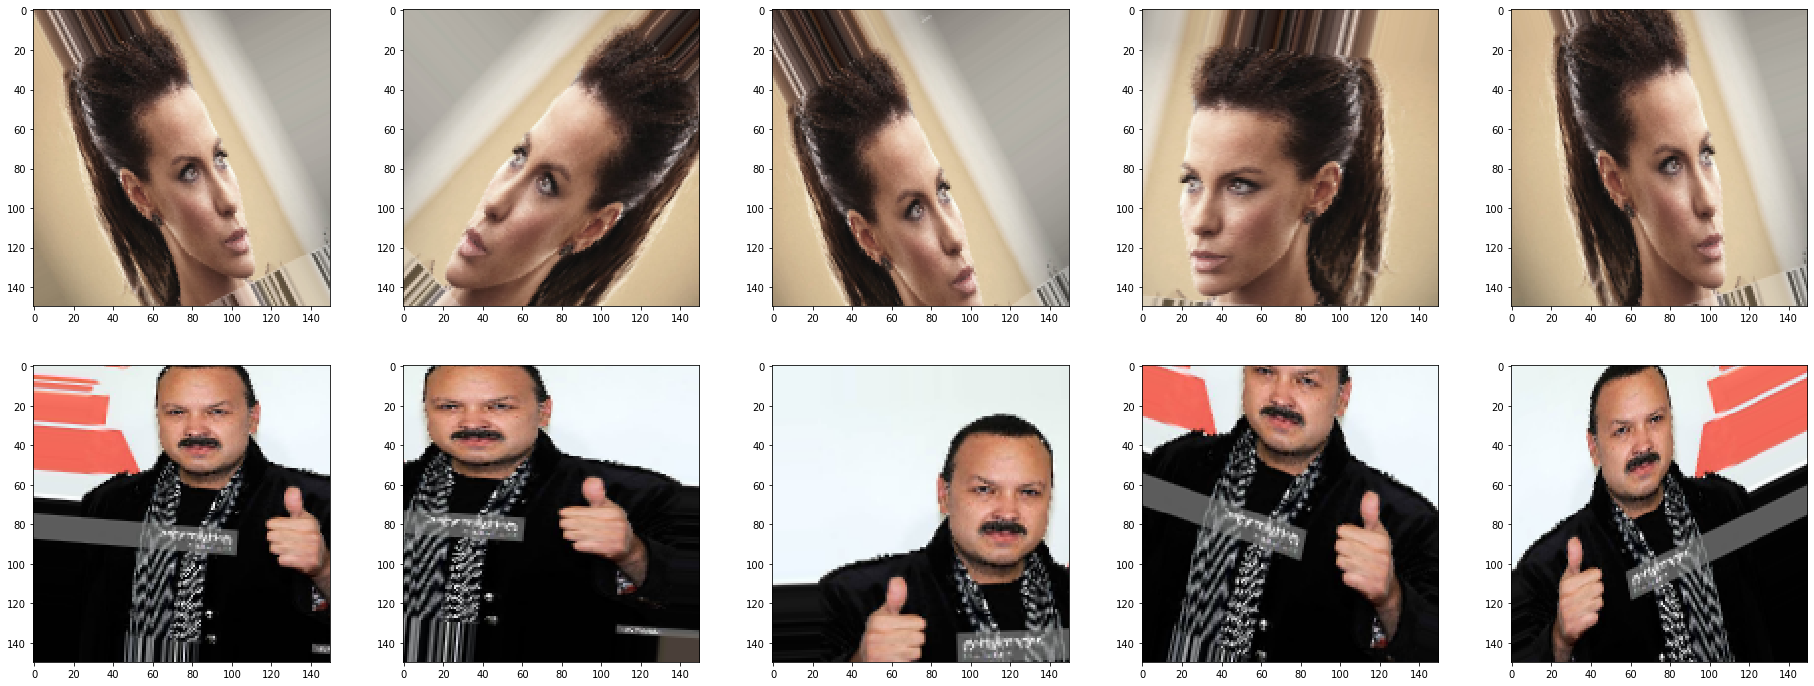

In [10]:
# lets see how these generated images would look.

nomissing_generator = train_datagen.flow(
    train_imgs[0:1], train_labels[0:1], batch_size=1)
nomissing = [next(nomissing_generator) for i in range(0, 5)]

fig, ax = plt.subplots(2, 5, figsize=(32, 12))
print('Labels', [item[1][0]for item in nomissing])
l = [ax[0][i].imshow(nomissing[i][0][0]) for i in range(0, 5)]

missing_generator = train_datagen.flow(
    train_imgs[520:521], train_labels[520:521], batch_size=1)
missing = [next(missing_generator) for i in range(0, 5)]
l2 = [ax[1][i].imshow(missing[i][0][0]) for i in range(0, 5)]
print('Labels', [item[1][0]for item in missing])

## VGG Pre-trained model with fine-tuning in the 4th and 5th convolution blocks plus image augmentation

we will  **unfreeze** the fourth and fifth convolution blocks of the VGG-16 model and adjust their weights.

In [11]:
# now we set up some configuration parameters and do some basic feauture pre processing
# The batch_size indicates the total number of images passed to the model per iteration.
#batch_size = 25
num_classes = 2  # The weights of the units in layers are updated after each iteration
epochs = 30  # n epoch is when the complete dataset has passed through the network once, that is, all the iterations are completed based on data batches
input_shape = (150, 150, 3)

In [12]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                  input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

In [13]:
vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Layer name', 'Layer trainable'])

,Layer type,Layer name,Layer trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [14]:
train_generator = train_datagen.flow(
    train_imgs, train_labels, batch_size=25)

test_generator = test_datagen.flow(
    test_imgs, test_labels, batch_size=15)

In [15]:
model_vgg_FT_imgaug = Sequential()
model_vgg_FT_imgaug.add(vgg_model)
model_vgg_FT_imgaug.add(Dense(512, activation='relu', input_dim=input_shape))
model_vgg_FT_imgaug.add(Dropout(0.3))
model_vgg_FT_imgaug.add(Dense(512, activation='relu'))
model_vgg_FT_imgaug.add(Dropout(0.3))
model_vgg_FT_imgaug.add(Dense(1, activation='sigmoid'))

model_vgg_FT_imgaug.compile(loss='binary_crossentropy',
                            optimizer=optimizers.RMSprop(lr=1e-5), metrics=['accuracy'])
model_vgg_FT_imgaug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
__________________________________

In [19]:
# lets now train the model

history_vgg_FT_imgaug = model_vgg_FT_imgaug.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                                                          validation_data=test_generator, validation_steps=50,
                                                          verbose=1)



Epoch 1/30
100/100 [==============================] - 611s 6s/step - loss: 0.3913 - accuracy: 0.8509 - val_loss: 0.4688 - val_accuracy: 0.8519
Epoch 2/30
100/100 [==============================] - 498s 5s/step - loss: 0.3045 - accuracy: 0.8792 - val_loss: 0.3532 - val_accuracy: 0.8594
Epoch 3/30
100/100 [==============================] - 500s 5s/step - loss: 0.2583 - accuracy: 0.8866 - val_loss: 0.4787 - val_accuracy: 0.8604
Epoch 4/30
100/100 [==============================] - 503s 5s/step - loss: 0.2095 - accuracy: 0.9182 - val_loss: 0.4931 - val_accuracy: 0.8768
Epoch 5/30
100/100 [==============================] - 504s 5s/step - loss: 0.1880 - accuracy: 0.9261 - val_loss: 0.5991 - val_accuracy: 0.8818
Epoch 6/30
100/100 [==============================] - 505s 5s/step - loss: 0.1404 - accuracy: 0.9410 - val_loss: 0.6685 - val_accuracy: 0.8783
Epoch 7/30
100/100 [==============================] - 505s 5s/step - loss: 0.1257 - accuracy: 0.9452 - val_loss: 0.2441 - val_accuracy: 0.8846

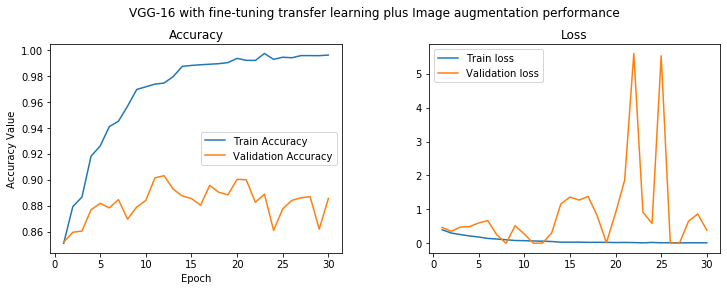

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle(
    'VGG-16 with fine-tuning transfer learning plus Image augmentation performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 31))
ax1.plot(
    epoch_list, history_vgg_FT_imgaug.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list,
         history_vgg_FT_imgaug.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_vgg_FT_imgaug.history['loss'], label='Train loss')
ax2.plot(
    epoch_list, history_vgg_FT_imgaug.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel = ('Loss Value')
ax2.set_xlabel = ('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

model_vgg_FT_imgaug.save('missing_tlearn_finetune_img_aug_cnn.h5')

In [16]:
# lets now train the  with epochs 12

history_vgg_FT_imgaug = model_vgg_FT_imgaug.fit_generator(train_generator, steps_per_epoch=100, epochs=12,
                                                          validation_data=test_generator, validation_steps=50,
                                                          verbose=1)



Epoch 1/12
100/100 [==============================] - 499s 5s/step - loss: 0.3840 - accuracy: 0.8692 - val_loss: 0.2216 - val_accuracy: 0.8575
Epoch 2/12
100/100 [==============================] - 497s 5s/step - loss: 0.3136 - accuracy: 0.8818 - val_loss: 0.3889 - val_accuracy: 0.8551
Epoch 3/12
100/100 [==============================] - 504s 5s/step - loss: 0.2830 - accuracy: 0.8850 - val_loss: 0.2894 - val_accuracy: 0.8504
Epoch 4/12
100/100 [==============================] - 500s 5s/step - loss: 0.2093 - accuracy: 0.9120 - val_loss: 0.2630 - val_accuracy: 0.8797
Epoch 5/12
100/100 [==============================] - 507s 5s/step - loss: 0.1756 - accuracy: 0.9260 - val_loss: 0.8551 - val_accuracy: 0.8732
Epoch 6/12
100/100 [==============================] - 498s 5s/step - loss: 0.1604 - accuracy: 0.9409 - val_loss: 0.0872 - val_accuracy: 0.8783
Epoch 7/12
100/100 [==============================] - 503s 5s/step - loss: 0.1303 - accuracy: 0.9464 - val_loss: 0.0986 - val_accuracy: 0.8846

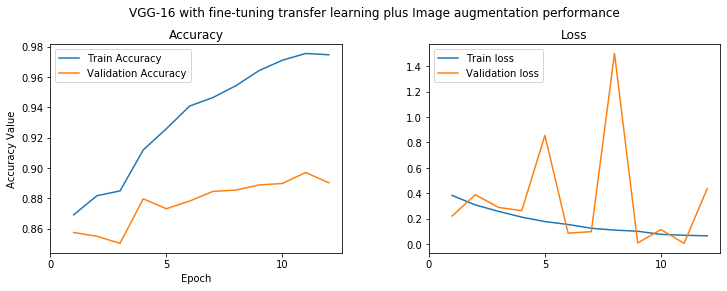

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle(
    'VGG-16 with fine-tuning transfer learning plus Image augmentation performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 13))
ax1.plot(
    epoch_list, history_vgg_FT_imgaug.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list,
         history_vgg_FT_imgaug.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 13, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_vgg_FT_imgaug.history['loss'], label='Train loss')
ax2.plot(
    epoch_list, history_vgg_FT_imgaug.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(0, 13, 5))
ax2.set_ylabel = ('Loss Value')
ax2.set_xlabel = ('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

model_vgg_FT_imgaug.save('missing_tlearn_finetune_img_aug_cnn_epochs_12.h5')